In [23]:
import os
import argparse
import wandb
import re
import clip
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# add the parent directory to the path
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
                
from utils.dcbm import *


In [25]:
# ----------------- Fix -----------------
embed_path = "../data/Embeddings/"
dataset = "cifar100"
class_labels_path = "../data/classes/cifar100_classes.txt"
segment_path = "../data/Segments/"
selected_image_concepts = "../data/Embeddings/subsets"
raw_path_dataset = "../data/Datasets/cifar100/test/"
raw_path ="../data/Segments/cifar100_SAM2/crops/"
# ----------------- Hyperparameters -----------------

model_name = "CLIP-ViT-L14"  # "CLIP-ViT-L14", "CLIP-RN50", CLIP-ViT-B16

segmentation_technique = "SAM2"  # GDINO, SAM, SAM2, DETR, MaskRCNN
concept_name = None # Define for GDINE [awa, sun, sun-lowthresh, cub...]

device = "cpu"

clusters = 2048
cluster_method = "kmeans"  # "hierarchical", "kmeans"
centroid_method = "median"  # "mean", "median"

concept_per_class = 50  # How many images for each class 5,10,20,50, None

one_hot = False
epochs = 200
lambda_1 = 1e-4
lr = 1e-4
batch_size = 32

crop = False  # True without background

use_wandb = False
project = "YOUR_PROJECT_NAME"  # Define your own project name within wandb

In [ ]:
cbm = CBM(
    embed_path, dataset, model_name, class_labels_path, device=device
)  # Initialize CBM

cbm.load_concepts(
    segment_path,
    segmentation_technique,
    concept_name,
    selected_image_concepts,
    concept_per_class,
    crop=crop,
)  # Load concepts with predefined segmentation technique and hyperparameters

if clusters is not None:  # if clustering is needed
    cbm.cluster_image_concepts(cluster_method, clusters)
else:
    cbm.clustered_concepts = cbm.image_segments

cbm.centroid_concepts(
    centroid_method
)  # Calculate centroids of the concepts with given method

cbm.preprocess_data(
    type_="standard", label_type=one_hot
)  # preprocess data for training
cbm_model = cbm.train(  # train the model
    num_epochs=epochs,
    lambda_1=lambda_1,
    lr=lr,
    batch_size=batch_size,
    device=device,
    project=project,
    to_print=False,
    early_stopping_patience=None,
    one_hot=one_hot,
    use_wandb=use_wandb,
)

In [ ]:
model = CBM_Model(
    cbm_model, cbm.clustered_concepts, cbm.preprocess_module, cbm.scaler, device=device
)
print("Predictions: ")
print(model.predict_processed(cbm.X_test[:200]))
print("True Classes: ")
print(np.argmax(cbm.y_test[:200], axis=1))

In [ ]:
id_image = 2

concept_ids, concept_weights = cbm.plot_instance_feature_importance(id_image)

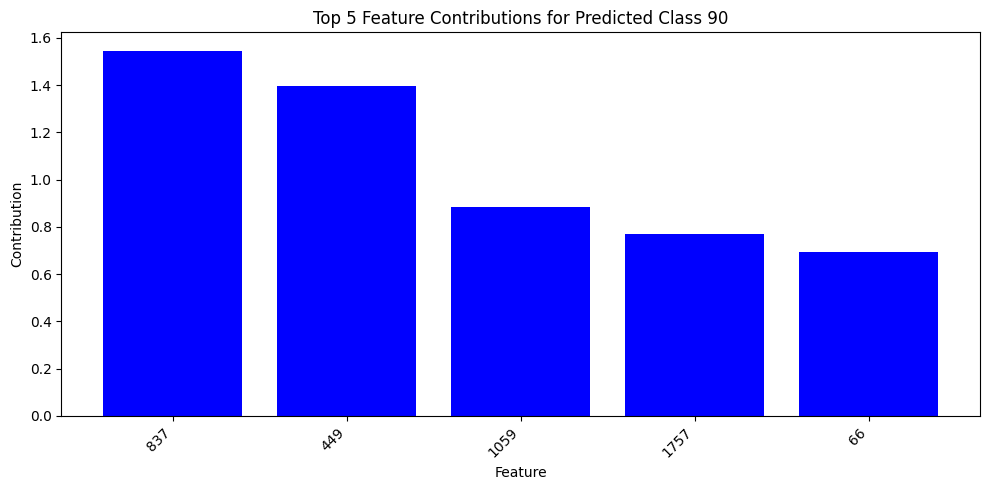

True Class: train
Predicted Class: train
['../data/Segments/cifar100_SAM2/crops/train/train_s_000508_OUT_CROP_1_X_.jpg', '../data/Segments/cifar100_SAM2/crops/sea/sea_s_001171_OUT_CROP_2_X_.jpg', '../data/Segments/cifar100_SAM2/crops/seal/fur_seal_s_000657_OUT_CROP_17_X_.jpg', '../data/Segments/cifar100_SAM2/crops/lamp/lamp_s_001775_OUT_CROP_0_X_.jpg', '../data/Segments/cifar100_SAM2/crops/skyscraper/skyscraper_s_000285_OUT_CROP_1_X_.jpg']
../data/Segments/cifar100_SAM2/crops/train/train_s_000508_OUT_CROP_1_X_.jpg
../data/Segments/cifar100_SAM2/crops/sea/sea_s_001171_OUT_CROP_2_X_.jpg
../data/Segments/cifar100_SAM2/crops/seal/fur_seal_s_000657_OUT_CROP_17_X_.jpg
../data/Segments/cifar100_SAM2/crops/lamp/lamp_s_001775_OUT_CROP_0_X_.jpg
../data/Segments/cifar100_SAM2/crops/skyscraper/skyscraper_s_000285_OUT_CROP_1_X_.jpg


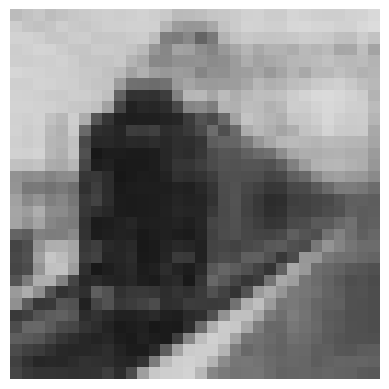

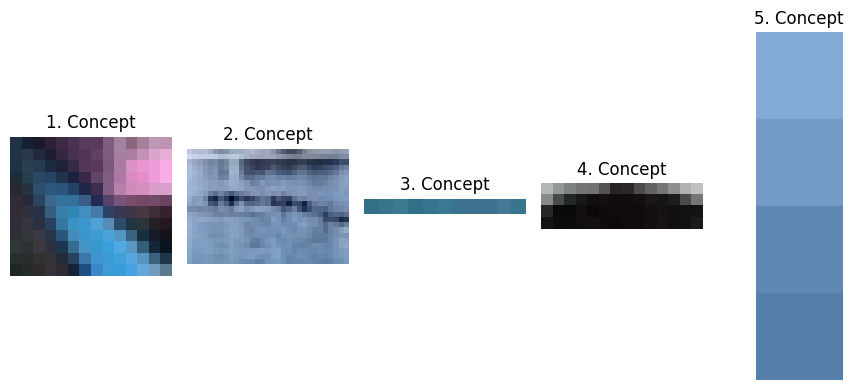

In [38]:
def display_images_with_main(image_paths, main_image_path, num_secondary=5):
    """
    Display a main image prominently and a series of smaller images in a row layout.

    Parameters:
    - image_paths (list): List of file paths for the secondary images.
    - main_image_path (str): File path of the main image to be displayed larger.
    - num_secondary (int): Number of secondary images to display. Default is 5.
    """
    # Remove duplicates from image paths
    image_paths = image_paths[:num_secondary]
    print(image_paths)
    # Display the main image
    main_img = Image.open(main_image_path)
    plt.imshow(main_img)
    plt.axis("off")

    # Set up the grid: main image in a larger size, followed by smaller images
    fig, axes = plt.subplots(1, num_secondary, figsize=(9, 4))

    # Display each of the secondary images
    for i, image_path in enumerate(image_paths):
        print(image_path)
        img = cv2.imread(image_path)

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"{i+1}. Concept")

    plt.tight_layout()
    plt.show()


def display_concepts(id_image, cbm, raw_path, raw_path_dataset):

    concept_ids, concept_weights = cbm.plot_instance_feature_importance(id_image)

    # Get the main image path

    folder_names = os.listdir(raw_path_dataset)
    image_name = list(cbm.data_test_raw.keys())[id_image]
    for local_folder_name in folder_names:
        local_file_names = os.listdir(os.path.join(raw_path_dataset, local_folder_name))
        png_name = image_name + ".png"
        if png_name in local_file_names:
            folder_name = local_folder_name
            break
    #image_name = image_name.split(folder_name + "_")[1]
    image_name = image_name + ".png"
    image_path_org = os.path.join(raw_path_dataset, folder_name, image_name)
    # Find paths to median images based on feature importance (as in your example)
    image_median_paths = []
    for idx in concept_ids[:5]:
        idx = int(idx)
        clustered_concepts = cbm.clustered_concepts_all
        data = clustered_concepts[idx]
        median_values = np.median(data, axis=0)
        distances = np.sum(np.abs(data - median_values), axis=1)
        median_index = np.argmin(distances)
        clustered_images = cbm.image_segments_names
        median_index = np.argsort(distances)
        # median_index is numeric which retrieves the embedding and path

        # Select up to n images closest to median
        n = 20
        median_entries = [clustered_images[idx][i] for i in median_index[:n]]
        # Process and add paths for the secondary images
        def construct_path(strings):
            correct_strings = []
            for substring in strings:
                local_folders = os.listdir(raw_path)
                for folder_name in local_folders:
                    if substring in os.listdir(os.path.join(raw_path, folder_name)):
                        folder_name_ = folder_name
                        substring = os.path.join(raw_path, folder_name_, substring)
                        correct_strings.append(substring)
                        break
            return correct_strings

        image_median_paths.append(construct_path(median_entries)[0])

    # Call the function to display images
    display_images_with_main(image_median_paths, image_path_org)


id_image = 300

display_concepts(id_image, cbm, raw_path, raw_path_dataset)